In [32]:
import meshio
import math

import numpy as np
from numpy import pi, sin, cos
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt

import pathlib
from pathlib import Path
import sys
import argparse
import os

if sys.version_info.major >= 3 and sys.version_info.minor >= 6:
    import urllib.request as urllib
else:
    import urllib
import tempfile
import re
import tqdm
import json
import open3d as o3d

## Download data

In [2]:
# adapted from https://gist.github.com/WaldJohannaU/55f5e35992ea91157b789b15eac4d432

BASE_URL = 'http://campar.in.tum.de/public_datasets/3RScan/'
DATA_URL = BASE_URL + 'Dataset/'
TOS_URL = 'http://campar.in.tum.de/public_datasets/3RScan/3RScanTOU.pdf'
TEST_FILETYPES = ['mesh.refined.v2.obj', 'mesh.refined.mtl', 'mesh.refined_0.png', 'sequence.zip']
# We only provide semantic annotations for the train and validation scans as well as the for the
# reference scans in the test set.
FILETYPES = TEST_FILETYPES + ['labels.instances.annotated.v2.ply', 'mesh.refined.0.010000.segs.v2.json', 'semseg.v2.json']

RELEASE = 'release_scans.txt'
HIDDEN_RELEASE = 'test_rescans.txt'

RELEASE_SIZE = '~94GB'
id_reg = re.compile(r"[a-z0-9]{8}-[a-z0-9]{4}-[a-z0-9]{4}-[a-z0-9]{4}-[a-z0-9]{12}")

def get_scans(scan_file):
    scan_lines = urllib.urlopen(scan_file)
    scans = []
    for scan_line in scan_lines:
        scan_line = scan_line.decode('utf8').rstrip('\n')
        match = id_reg.search(scan_line)
        if match:
            scan_id = match.group()
            scans.append(scan_id)
    return scans

def download_release(release_scans, out_dir, file_types):
    print('Downloading 3RScan release to ' + out_dir + '...')
    for scan_id in tqdm.tqdm(release_scans):
        scan_out_dir = os.path.join(out_dir, scan_id)
        download_scan(scan_id, scan_out_dir, file_types)
    print('Downloaded 3RScan release.')

def download_file(url, out_file):
    # print(url)
    out_dir = os.path.dirname(out_file)
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    if not os.path.isfile(out_file):
        # print('\t' + url + ' > ' + out_file)
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        urllib.urlretrieve(url, out_file_tmp) 
        os.rename(out_file_tmp, out_file)
    else: pass
        # print('WARNING: skipping download of existing file ' + out_file)

def download_scan(scan_id, out_dir, file_types):
    # print('Downloading 3RScan scan ' + scan_id + ' ...')
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    for ft in file_types:
        url = DATA_URL + '/' + scan_id + '/' + ft
        out_file = out_dir + '/' + ft
        download_file(url, out_file)
    # print('Downloaded scan ' + scan_id)
    

### Define file type and scans to download

In [3]:
file_type = 'semseg.v2.json'
file_types = [file_type]
scan_id = None  # None ==> download all files
out_dir = 'all_3rscans'
pathlib.Path(out_dir).mkdir(exist_ok=True)

### Download files

In [4]:
release_scans = get_scans(BASE_URL + RELEASE)
test_scans = get_scans(BASE_URL + HIDDEN_RELEASE)
file_types_test = TEST_FILETYPES;

if file_type not in TEST_FILETYPES:
    file_types_test = []
else:
    file_types_test = [file_type]
if scan_id:  # download single scan
    if scan_id not in release_scans and scan_id not in test_scans:
        print('ERROR: Invalid scan id: ' + scan_id)
    else:
        out_dir = os.path.join(args.out_dir, scan_id)

        if scan_id in release_scans:
            download_scan(scan_id, out_dir, file_types)
        elif scan_id in test_scans:
            download_scan(scan_id, out_dir, file_types_test)
else: # download entire release
    if len(file_types) == len(FILETYPES):
        print('WARNING: You are downloading the entire 3RScan release which requires ' + RELEASE_SIZE + ' of space.')
    else:
        print('WARNING: You are downloading all 3RScan scans of type ' + file_types[0])
    print('Note that existing scan directories will be skipped. Delete partially downloaded directories to re-download.')
    print('***')
    print('Press any key to continue, or CTRL-C to exit.')
    key = input('')
    download_release(release_scans, out_dir, file_types)
    download_release(test_scans, out_dir, file_types_test)

Note that existing scan directories will be skipped. Delete partially downloaded directories to re-download.
***
Press any key to continue, or CTRL-C to exit.


100%|███████████████████████████████████| 1381/1381 [00:00<00:00, 119215.71it/s]


Downloaded 3RScan release.


100%|█████████████████████████████████████| 101/101 [00:00<00:00, 200579.88it/s]

Downloaded 3RScan release.


## Parse data

In [5]:
data_dir = Path('all_3rscans')
# Warning: not all scenes have a semseg.v2.json (1381 vs 1482)
semseg_files = [f / 'semseg.v2.json' for f in data_dir.iterdir() if f.is_dir() and (f / 'semseg.v2.json').exists()]

In [6]:
scenes = []
for fp in semseg_files:
    with open(fp) as f:
        j = json.load(f)
    bboxes = []
    for obj in j['segGroups']:  
        bboxes.append({
            'centroid': obj['obb']['centroid'],
            'axesLengths': obj['obb']['axesLengths'],
            'normalizedAxes': obj['obb']['normalizedAxes'],
            'label': obj['label'],
            'id': fp.parts[1],
        })
    scenes.append(bboxes)

In [7]:
# `scenes` is a list of scenes.
# each scene is a list of objects.
# each object is specified by a bounding box.
scenes[0][0]

{'centroid': [-1.5771138134959835, 1.7649075851651648, -1.097637007712937],
 'axesLengths': [1.5694338937692993, 0.8191460187924052, 0.8655946113532621],
 'normalizedAxes': [0.8626997470855713,
  -0.5057164430618286,
  -1.1229160780375582e-16,
  0,
  -2.220446049250313e-16,
  1,
  -0.5057164430618286,
  -0.8626997470855713,
  -1.915578245105401e-16],
 'label': 'bean bag',
 'id': '0cac755e-8d6f-2d13-8c6a-c0979ca34a4f'}

## Visualize bounding boxes

### Generate mesh of all bounding boxes and export as `mesh.obj`.

In [54]:
scene_id = '19eda6f4-55aa-29a0-8893-8eac3a4d8193'
scene = [s for s in scenes if s[0]['id'] == scene_id][0]
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
# don't include features of buildings
blacklist = ["wall", "floor", "ceiling", "window", "wall frame", "window frame", "wall /other room", "floor /other room", "roof", 
"doorframe /other room", "windows", "ceiling /other room",
"slanted wall", "pavement", "stairs"]
objs = [o for o in scene if (o['label'] not in blacklist)]
bbox_annotations = []
for idx, obj in enumerate(objs):
    width, depth, height = obj["axesLengths"]
    print(str(idx).rjust(3), obj['label'].rjust(10), 'volume:', "{:.2f}".format(width * height * depth))
    # scale.
    obb = o3d.geometry.TriangleMesh.create_box(width=width, height=height, depth=depth)
    # center.
    obb = obb.translate(-np.array([width, height, depth])/2)
    # rotate around z-axis.
    rot_vec_norm = np.array([0., 0., 1.])
    ax, ay = obj["normalizedAxes"][:2]
    angle = math.atan2(ay, ax)
    rot_vec = angle * rot_vec_norm
    rot_mat = o3d.geometry.get_rotation_matrix_from_axis_angle(rot_vec)
    obb = obb.rotate(rot_mat)
    # translate
    obb = obb.translate(obj["centroid"])
    mesh += obb
    # add label to plot
    bbox_annotations.append(dict(
        x=obj["centroid"][0],
        y=obj["centroid"][1],
        z=obj["centroid"][2] + depth/2 + 0.01,
        text=obj['label'],
        arrowhead=1,
    ))
o3d.io.write_triangle_mesh("mesh.obj", mesh)

  0   tv stand volume: 0.18
  1      bench volume: 0.19
  2      chair volume: 0.30
  3       sofa volume: 6.53
  4      plant volume: 0.57
  5      shelf volume: 0.17
  6         tv volume: 0.13
  7    clothes volume: 0.15
  8     pillow volume: 0.05
  9       rack volume: 0.01
 10       door volume: 0.19
 11       door volume: 0.16
 12     pillow volume: 0.29
 13        bag volume: 0.02
 14      table volume: 0.18
 15     pillow volume: 1.01
 16       item volume: 0.00
 17     pillow volume: 0.00
 18     pillow volume: 0.03
 19        bag volume: 0.12
 20  sidecouch volume: 0.28
 21       item volume: 0.00
 22      table volume: 0.21
 23  doorframe volume: 0.36
 24      plant volume: 1.07
 25      shelf volume: 0.46
 26       door volume: 1.44
 27        box volume: 0.04
 28     mirror volume: 0.34
 29  doorframe volume: 0.67
 30      chair volume: 0.33
 31      table volume: 0.23
 32       item volume: 0.01
 33      plant volume: 0.85
 34      stand volume: 0.01


True

### Plot `mesh.obj`.

In [55]:
# adapted from https://nbviewer.org/github/empet/Hollow-mask-illusion/blob/main/Hollow-Mask-illusion-Animation.ipynb

msh = meshio.read("mesh.obj") # https://raw.githubusercontent.com/empet/Datasets/master/Meshes/face-mesh.obj
verts = msh.points
I, J, K =  msh.cells_dict["triangle"].T
x, y, z = verts.T

fig = make_subplots(rows=1, cols=1, 
                   horizontal_spacing=0.015,
                   specs=[[{'type': 'scene'}]])

colorscale = [[0, 'rgb(100,100,100)'], 
              [1, 'rgb(250,250,250)']]
fig.add_trace(go.Mesh3d(x=x, y=y, z=z, 
                          i=I, j=J, k=K, 
                          intensity=z, 
                          colorscale =colorscale,
                          showscale=False,
                          lighting=dict(ambient=0.1,
                                        diffuse=1,
                                        fresnel=3,  
                                        specular=0.5, 
                                        roughness=0.05),
                          lightposition=dict(x=100,
                                             y=200,
                                             z=1000)
                       ), 1, 1)
axis_prop =dict(visible=False, autorange=False)

plotly_scenes = dict(xaxis=dict(range=[-11.41, 11.41], **axis_prop),
              yaxis=dict(range=[-11.41, 11.41], **axis_prop),
              zaxis=dict(range=[-14.67, 10.37], **axis_prop),
              camera_eye=dict(x=-1.85, y=-1.85, z=0.65),
              aspectratio=dict(x=1.15, y=1.15, z=1.1),
              annotations = bbox_annotations)

fig.update_layout(title_text=f"Bounding boxes for scene {scene_id}", title_x=0.5, title_y=0.95,
                  font_size=12, font_color="white",
                  width=800, height=400, autosize=False, 
                  margin=dict(t=2, r=2, b=2, l=2),
                  paper_bgcolor='black',
                  scene=plotly_scenes)
fig.show()

# Some statistics on the dataset

### Ensure that all objects are only rotated around the z-axis.

In [56]:
z_axis = np.array([0, 0, 1])
dists = []
for s in scenes:
    for o in s:
        ax = o['normalizedAxes'][3:6]
        d = np.linalg.norm(ax - z_axis)
        dists.append(d)
dists = np.array(dists)

In [57]:
print(dists.min(), dists.max())

2.220446049250313e-16 2.220446049250313e-16


### Histogram of objects per scene

(array([278., 561., 374., 110.,  44.,  10.,   0.,   0.,   0.,   4.]),
 array([  2. ,  16.4,  30.8,  45.2,  59.6,  74. ,  88.4, 102.8, 117.2,
        131.6, 146. ]),
 <BarContainer object of 10 artists>)

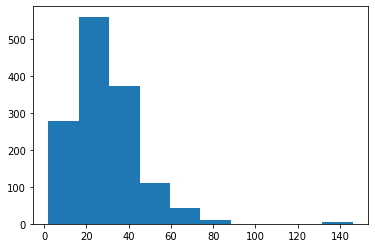

In [97]:
nobjs = [len(s) for s in scenes]
plt.hist(nobjs)

In [71]:
from collections import Counter
sorted(Counter(nobjs).items(), key= lambda x: x[0])

[(2, 8),
 (3, 3),
 (4, 4),
 (5, 4),
 (6, 10),
 (7, 14),
 (8, 16),
 (9, 22),
 (10, 21),
 (11, 21),
 (12, 26),
 (13, 25),
 (14, 27),
 (15, 31),
 (16, 38),
 (17, 51),
 (18, 29),
 (19, 31),
 (20, 40),
 (21, 36),
 (22, 43),
 (23, 43),
 (24, 43),
 (25, 47),
 (26, 33),
 (27, 49),
 (28, 45),
 (29, 35),
 (30, 33),
 (31, 36),
 (32, 39),
 (33, 26),
 (34, 35),
 (35, 26),
 (36, 22),
 (37, 31),
 (38, 22),
 (39, 31),
 (40, 23),
 (41, 25),
 (42, 18),
 (43, 16),
 (44, 22),
 (45, 10),
 (46, 13),
 (47, 11),
 (48, 19),
 (49, 6),
 (50, 9),
 (51, 4),
 (52, 13),
 (53, 1),
 (54, 6),
 (55, 2),
 (56, 2),
 (57, 4),
 (58, 10),
 (59, 10),
 (60, 2),
 (61, 2),
 (62, 5),
 (63, 3),
 (64, 4),
 (65, 4),
 (66, 4),
 (67, 3),
 (68, 2),
 (69, 4),
 (70, 4),
 (71, 4),
 (73, 3),
 (74, 2),
 (75, 1),
 (76, 2),
 (77, 2),
 (80, 1),
 (81, 1),
 (83, 1),
 (84, 1),
 (87, 1),
 (89, 1),
 (139, 1),
 (143, 1),
 (145, 1),
 (147, 1)]

### Object types and counts

In [53]:
obj_types = {}
for s in scenes:
    for o in s:
        obj_types[o['label']] = obj_types.get(o['label'], 0) + 1

import operator
sorted_types = sorted(obj_types.items(), key=operator.itemgetter(1), reverse=True)

sorted_types

[('wall', 5914),
 ('chair', 2312),
 ('pillow', 1638),
 ('box', 1583),
 ('shelf', 1478),
 ('floor', 1388),
 ('ceiling', 1295),
 ('plant', 1029),
 ('door', 910),
 ('window', 898),
 ('table', 892),
 ('item', 836),
 ('lamp', 829),
 ('curtain', 800),
 ('object', 677),
 ('cabinet', 633),
 ('picture', 606),
 ('bag', 476),
 ('light', 412),
 ('doorframe', 397),
 ('clothes', 397),
 ('armchair', 391),
 ('kitchen cabinet', 387),
 ('sink', 387),
 ('towel', 348),
 ('heater', 333),
 ('blanket', 329),
 ('stool', 327),
 ('trash can', 326),
 ('commode', 289),
 ('desk', 278),
 ('cushion', 278),
 ('monitor', 274),
 ('wardrobe', 266),
 ('windowsill', 253),
 ('sofa', 252),
 ('bed', 245),
 ('basket', 241),
 ('tv', 218),
 ('bench', 215),
 ('coffee table', 178),
 ('nightstand', 167),
 ('clutter', 166),
 ('radiator', 166),
 ('toilet', 160),
 ('bath cabinet', 158),
 ('blinds', 157),
 ('kitchen counter', 145),
 ('bucket', 142),
 ('mirror', 134),
 ('decoration', 134),
 ('stand', 132),
 ('couch', 120),
 ('backpack'

### Histogram of bounding box volumes

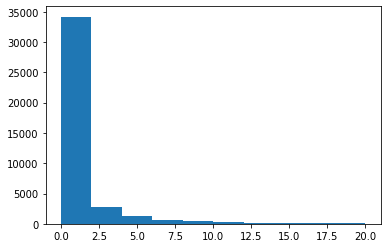

In [98]:
volumes = [math.prod(o['axesLengths']) for s in scenes for o in s]
plt.hist(volumes);

## Clean data & export dataset

1. Remove bounding boxes with volume > 20 $\mathrm{m}^3$.

In [73]:
scenes = [[o for o in s if math.prod(o['axesLengths']) <= 20] for s in scenes]    

2. Create scene samples with 10 bounding boxes each. Ignore scenes with fewer bounding boxes. Split up scenes with more bounding boxes.

In [79]:
nbboxes = 10
samples = []
for s in scenes:
    for idx in range(0, len(s)-(nbboxes-1), nbboxes):
        samples.append(s[idx:idx+nbboxes])

3. Create dataset $\mathcal{D}$ of samples $s \in \mathbb{R}^{10\times 7}$, where each column in $s$ contains an object's size, position and rotation around the z-axis.  

In [91]:
data = []
for samp in samples:
    s = []
    for obj in samp:
        width, depth, height = obj["axesLengths"]
        x, y, z = obj["centroid"]
        ax, ay = obj["normalizedAxes"][:2]
        angle = math.atan2(ay, ax)
        s.append([width, depth, height, x, y, z, angle])
    data.append(s)
dataset = np.array(data)
dataset.shape

(3372, 10, 7)

4. Save $\mathcal{D}$ to the disk.

In [96]:
with open("bounding_boxes.npy", "wb") as f:
    np.save(f, dataset)